In [106]:
#load the packages
import pandas as pd
from collections import Counter
from string import punctuation
import re
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.model_selection import GridSearchCV
from pprint import pprint


[nltk_data] Downloading package stopwords to C:\Users\Luke-
[nltk_data]     Workstation\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Function for displaying the topics

In [107]:
# This function comes from the blueprint for text analytics 

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))



Function for displaying the wordcloud

In [108]:
# display word cloud function
def wordcloud_topics(model, features, no_top_words=30):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100,
            width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")


#load the data

In [109]:
#load the dataset
df = pd.read_pickle('C:\\Users\\Luke-Workstation\\Documents\\GitHub\\drug-labels\\data\\processed\\cleaned_data.pkl')
df.sample(10)


,target,text,tokens,tokens_no_eng_stopwords,tokens_no_stopwords
75445,ORAL,DIRECTIONS chew 2 to 4 tablets thoroughly as n...,"[directions, chew, to, tablets, thoroughly, as...","[directions, chew, tablets, thoroughly, needed...","[chew, tablets, thoroughly, needed, meals, bed..."
17476,ORAL,2 DOSAGE AND ADMINISTRATION See full prescribi...,"[dosage, and, administration, see, full, presc...","[dosage, administration, see, full, prescribin...","[see, full, prescribing, information, recommen..."
5859,ORAL,DOSAGE AND ADMINISTRATION Carefully consider t...,"[dosage, and, administration, carefully, consi...","[dosage, administration, carefully, consider, ...","[carefully, consider, potential, benefits, ris..."
80602,TOPICAL,Directions Pump a small amount of foam into pa...,"[directions, pump, a, small, amount, of, foam,...","[directions, pump, small, amount, foam, palm, ...","[pump, small, amount, foam, palm, hand, rub, t..."
25507,TOPICAL,Directions Adults and children 2 yr. of age an...,"[directions, adults, and, children, yr, of, ag...","[directions, adults, children, yr, age, older,...","[adults, children, yr, age, older, shake, well..."
45968,ORAL,Directions ▪ shake well before use ▪ only use ...,"[directions, ▪, shake, well, before, use, ▪, o...","[directions, ▪, shake, well, use, ▪, use, dose...","[▪, shake, well, use, ▪, use, dose, cup, provi..."
39015,ORAL,Directions do not take more than directed adul...,"[directions, do, not, take, more, than, direct...","[directions, take, directed, adults, children,...","[take, directed, adults, children, years, take..."
42668,ORAL,DOSAGE AND ADMINISTRATION Hypertension Monothe...,"[dosage, and, administration, hypertension, mo...","[dosage, administration, hypertension, monothe...","[hypertension, monotherapy, recommended, initi..."
83065,ORAL,Directions Mix one sachet of Mucilin briskly w...,"[directions, mix, one, sachet, of, mucilin, br...","[directions, mix, one, sachet, mucilin, briskl...","[mix, one, sachet, mucilin, briskly, least, on..."
12563,ORAL,DIRECTIONS: Adults and children 5 to 10 drops ...,"[directions, adults, and, children, to, drops,...","[directions, adults, children, drops, orally, ...","[adults, children, drops, orally, times, daily..."


In [110]:
#check the different classes in the target variable
print(df['target'].unique())
print()

print("There are",len(df['target'].unique()),"classes")

['ORAL' 'OPHTHALMIC' 'TOPICAL' 'INTRAVENOUS' 'RESPIRATORY (INHALATION)'
 'VAGINAL' 'SUBLINGUAL' 'INTRAMUSCULAR' 'DENTAL' 'IRRIGATION'
 'INTRATHECAL' 'EPIDURAL' 'SUBCUTANEOUS' 'NASAL' 'RECTAL' 'CUTANEOUS'
 'INTRA-ARTICULAR' 'TRANSDERMAL' 'INTRAOCULAR' 'PERCUTANEOUS'
 'INTRACARDIAC' 'INTRAVITREAL' 'AURICULAR (OTIC)' 'SUBMUCOSAL' 'BUCCAL'
 'PERINEURAL' 'INFILTRATION' 'INTRALESIONAL' 'PERIODONTAL' 'PARENTERAL'
 'INTRACAVITARY' 'INTRAVASCULAR' 'ENDOTRACHEAL' 'INTRACAVERNOUS'
 'EXTRACORPOREAL' 'INTRADERMAL' 'INTRA-ARTERIAL' 'SUBARACHNOID'
 'INTRAUTERINE' 'OROPHARYNGEAL' 'INTRATYMPANIC' 'INTRACAMERAL'
 'HEMODIALYSIS' 'URETHRAL' 'INTRAPERITONEAL' 'TRANSMUCOSAL' 'INTRAVESICAL'
 'ENTERAL' 'INTRABRONCHIAL' 'INTRACANALICULAR' 'URETERAL' 'RETROBULBAR'
 'INTRAPLEURAL' 'INTRASPINAL' 'SUBGINGIVAL' 'INTRASINAL'
 'INTRAVENTRICULAR']

There are 57 classes


In [111]:
#check the top classes counts
df['target'].value_counts().head(10)

ORAL                        46773
TOPICAL                     27962
INTRAVENOUS                  2871
DENTAL                       1402
INTRAMUSCULAR                1386
OPHTHALMIC                   1347
SUBLINGUAL                    798
NASAL                         644
SUBCUTANEOUS                  327
RESPIRATORY (INHALATION)      326
Name: target, dtype: int64

There are 57 classes in the target variable we choose to use the Top 5 classes as that account for over 90% of the drugs, the other classes will be assigned to class  other

In [112]:
#create a new dataframe with just the 5 classes
df.loc[~df['target'].isin(['ORAL', 'TOPICAL', 'INTRAVENOUS', 'DENTAL', 'INTRAMUSCULAR']), 'target'] = 'OTHER'
list(df['target'].unique())

['ORAL', 'OTHER', 'TOPICAL', 'INTRAVENOUS', 'INTRAMUSCULAR', 'DENTAL']

In [113]:
#check the updated value counts
df['target'].value_counts()

ORAL             46773
TOPICAL          27962
OTHER             5253
INTRAVENOUS       2871
DENTAL            1402
INTRAMUSCULAR     1386
Name: target, dtype: int64

In [115]:
#prep the data for vectorization
df['tokens_str'] = df.apply(lambda row : (' '.join(row['tokens_no_stopwords'])), axis = 1)
df.head()

,target,text,tokens,tokens_no_eng_stopwords,tokens_no_stopwords,tokens_str
0,ORAL,"DOSAGE Adults- Take 4 or 6 Pellets by mouth, t...","[dosage, adults, take, or, pellets, by, mouth,...","[dosage, adults, take, pellets, mouth, three, ...","[adults, take, pellets, mouth, three, times, d...",adults take pellets mouth three times daily su...
1,ORAL,DIRECTIONS Adults: Dissolve 3 to 5 under the t...,"[directions, adults, dissolve, to, under, the,...","[directions, adults, dissolve, tongue, three, ...","[adults, dissolve, tongue, three, times, day, ...",adults dissolve tongue three times day directe...
2,OTHER,DOSAGE AND ADMINISTRATION The recommended dosa...,"[dosage, and, administration, the, recommended...","[dosage, administration, recommended, dosage, ...","[recommended, regimen, treatment, bacterial, c...",recommended regimen treatment bacterial conjun...
3,ORAL,2 DOSAGE AND ADMINISTRATION Use the lowest eff...,"[dosage, and, administration, use, the, lowest...","[dosage, administration, use, lowest, effectiv...","[use, lowest, effective, shortest, duration, c...",use lowest effective shortest duration consist...
4,TOPICAL,"Directions wet face, apply to hand, massage fa...","[directions, wet, face, apply, to, hand, massa...","[directions, wet, face, apply, hand, massage, ...","[wet, face, apply, hand, massage, face, gently...",wet face apply hand massage face gently rinse ...


In [116]:
# TF-IDF text vectorization
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['tokens_str'])
tfidf_text_vectors.shape


c:\Users\Luke-Workstation\Envs\drug-labels\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(85647, 13047)


# Fitting a Non-Negative Matrix Factorization Model

In [117]:
nmf_text_model = NMF(n_components=5, random_state=2022)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  years (6.70)
  children (6.04)
  doctor (3.89)
  age (3.58)
  hours (3.17)

Topic 01
  sun (8.68)
  protection (3.37)
  measures (3.27)
  sunscreen (3.05)
  skin (3.04)

Topic 02
  mg (3.36)
  dose (1.85)
  patients (1.48)
  daily (1.15)
  day (1.09)

Topic 03
  hands (9.44)
  product (6.77)
  dry (5.77)
  rub (4.76)
  thoroughly (3.70)

Topic 04
  symptoms (8.10)
  tongue (7.94)
  pellets (7.76)
  relieved (6.60)
  dissolve (6.45)


In [118]:
#compare the nmf model to the original tallys
df['Topic'] = W_text_matrix .argmax(axis=1)
pd.crosstab(df['Topic'], df['target'])

target,DENTAL,INTRAMUSCULAR,INTRAVENOUS,ORAL,OTHER,TOPICAL
Topic,,,,,,
0,1187,0,0,14994,1680,5001
1,2,0,0,9,42,7128
2,35,1382,2870,24620,2272,1287
3,162,1,1,17,332,13888
4,16,3,0,7133,927,658


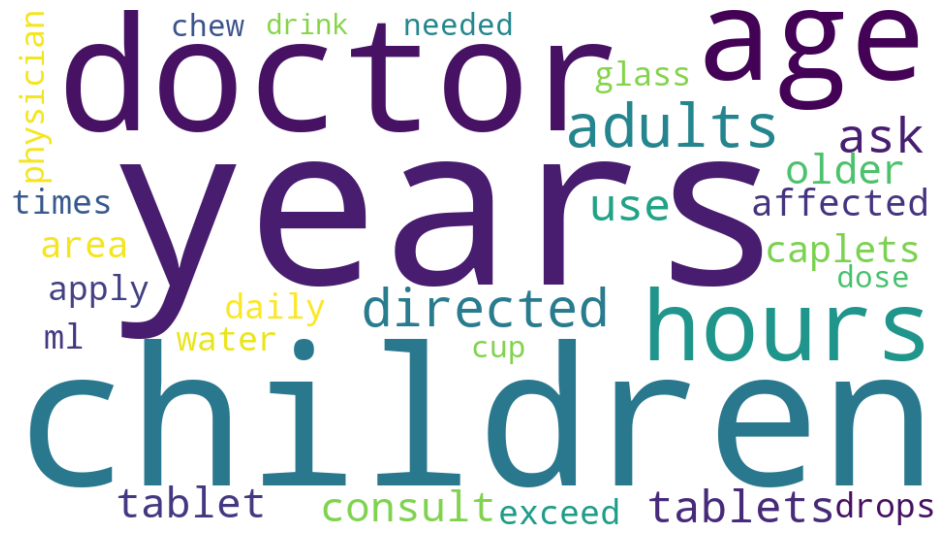

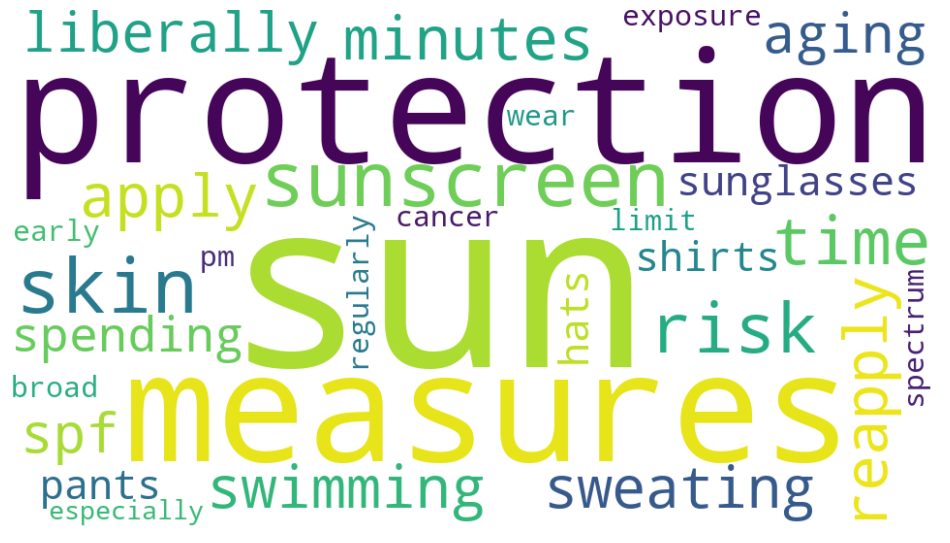

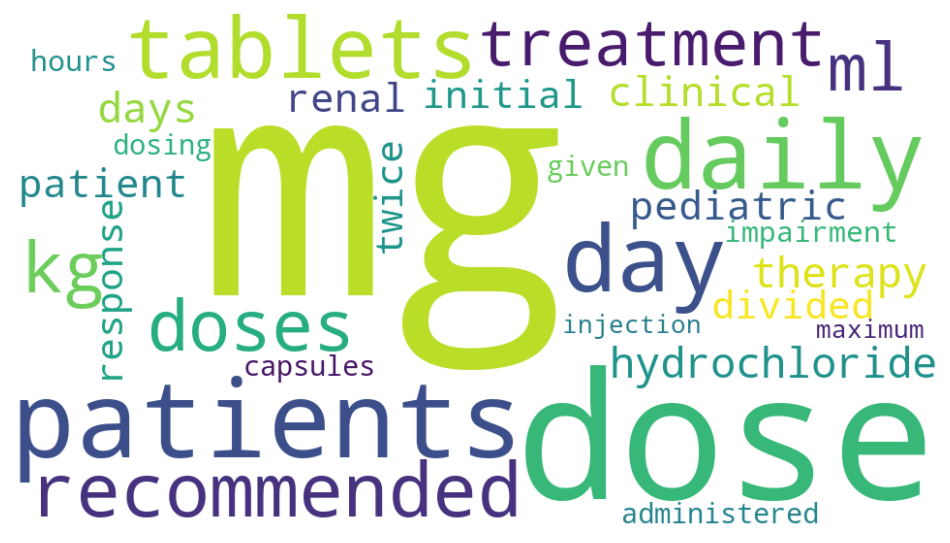

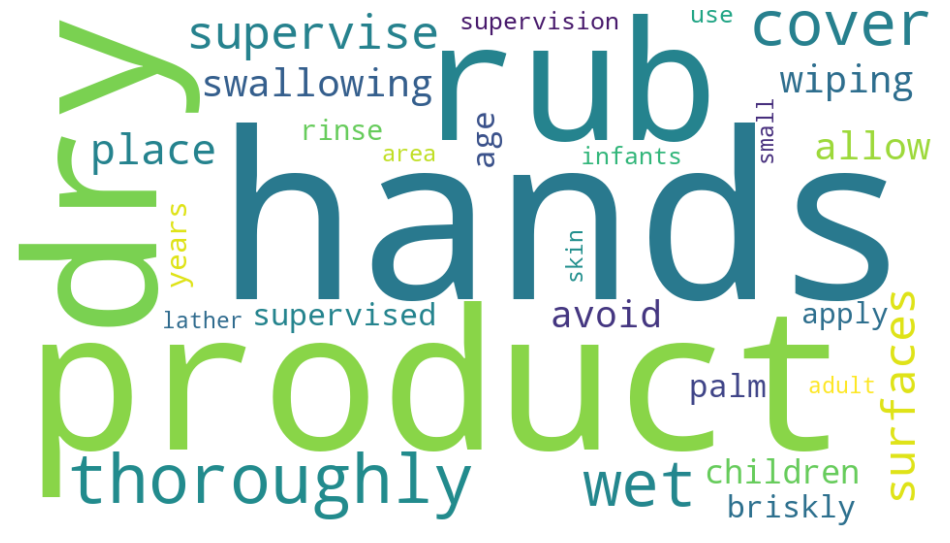

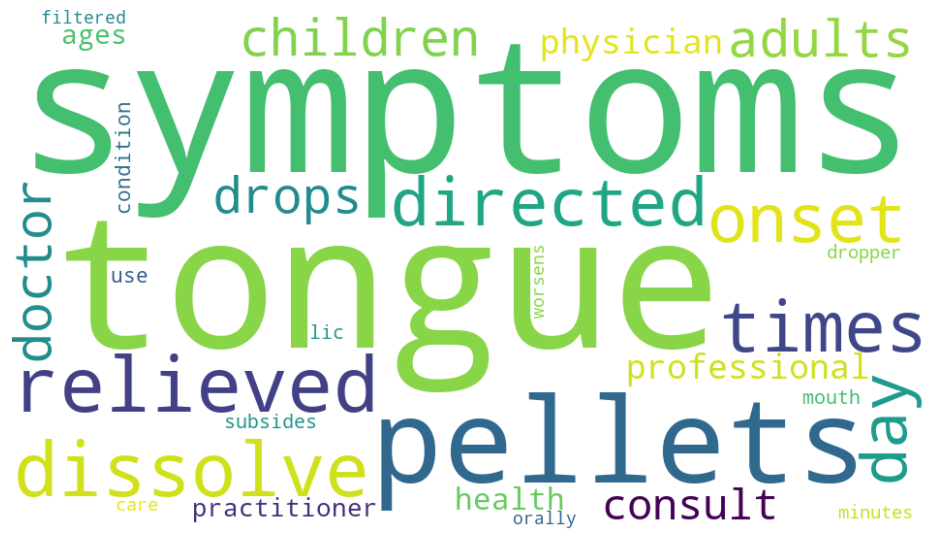

In [119]:
#plot the nmf wordcloud
wordcloud_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())

# Fitting an LSA Model

In [120]:
# Fit truncated SVD model (LSA)
svd_text_model = TruncatedSVD(n_components=5, random_state=2022)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

# call display_topics on your model
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  children (2.36)
  years (2.33)
  mg (1.56)
  doctor (1.52)
  age (1.43)

Topic 01
  sun (14.36)
  protection (5.56)
  measures (5.38)
  skin (5.07)
  sunscreen (5.05)

Topic 02
  mg (4.00)
  sun (2.93)
  dose (2.00)
  patients (1.81)
  protection (1.15)

Topic 03
  hands (7.69)
  product (5.30)
  dry (4.64)
  rub (3.84)
  thoroughly (2.99)

Topic 04
  pellets (9.96)
  tongue (9.80)
  symptoms (8.94)
  relieved (8.36)
  dissolve (7.37)


In [121]:
#compare the LSA model to the original tallys
df['Topic'] = W_svd_text_matrix .argmax(axis=1)
pd.crosstab(df['Topic'], df['target'])

target,DENTAL,INTRAMUSCULAR,INTRAVENOUS,ORAL,OTHER,TOPICAL
Topic,,,,,,
0,1384,309,675,26380,3921,11315
1,0,0,0,0,13,6281
2,2,1074,2194,16718,769,140
3,10,1,2,1,108,10191
4,6,2,0,3674,442,35


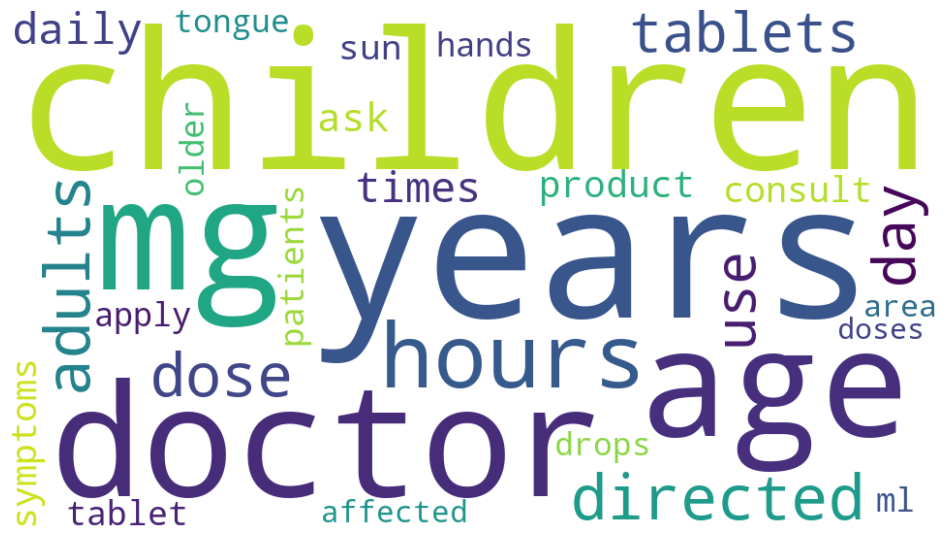

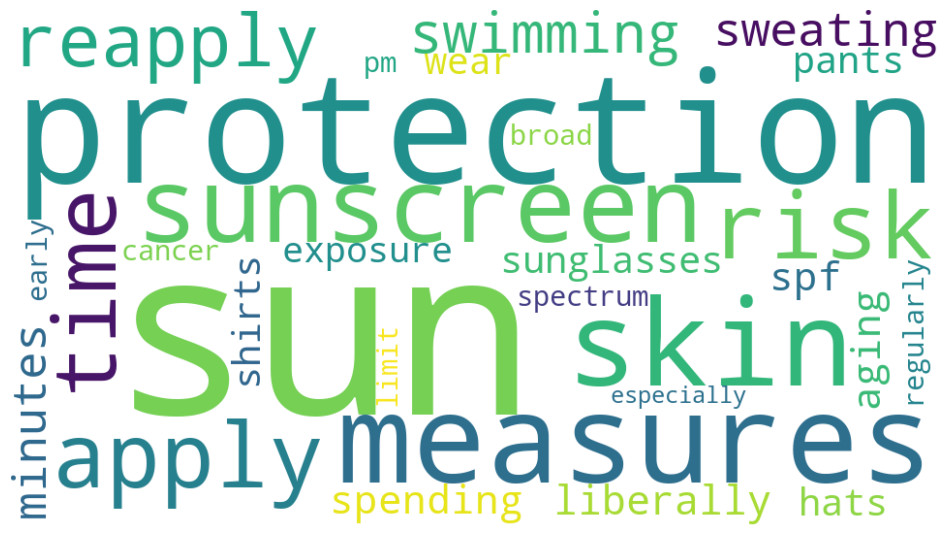

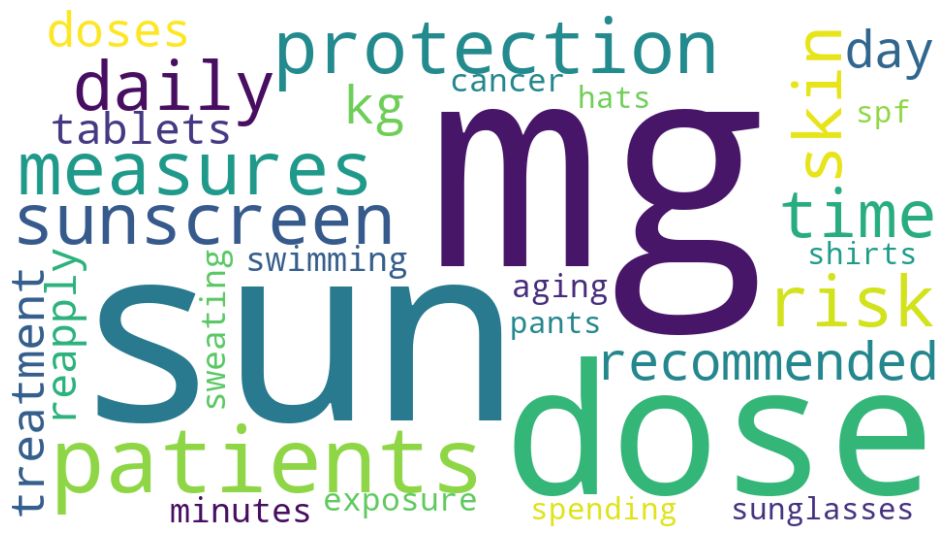

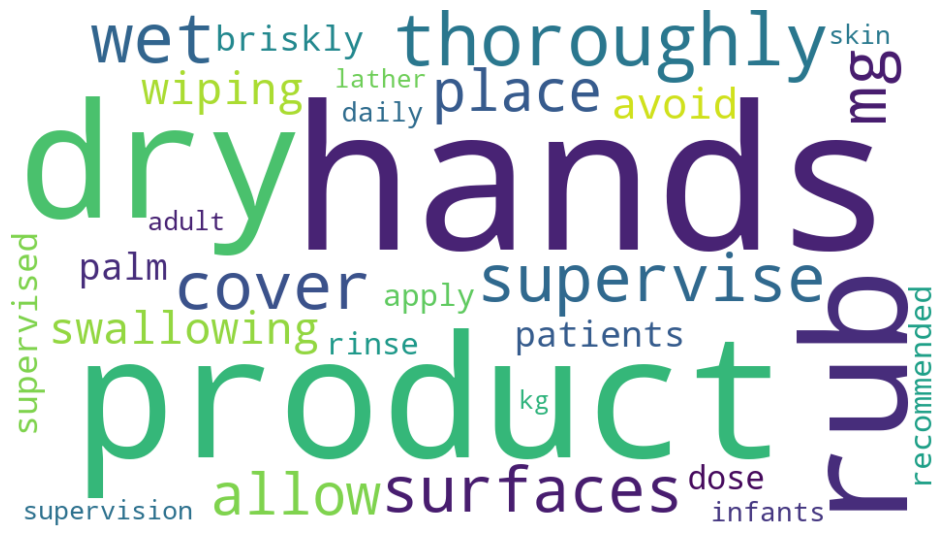

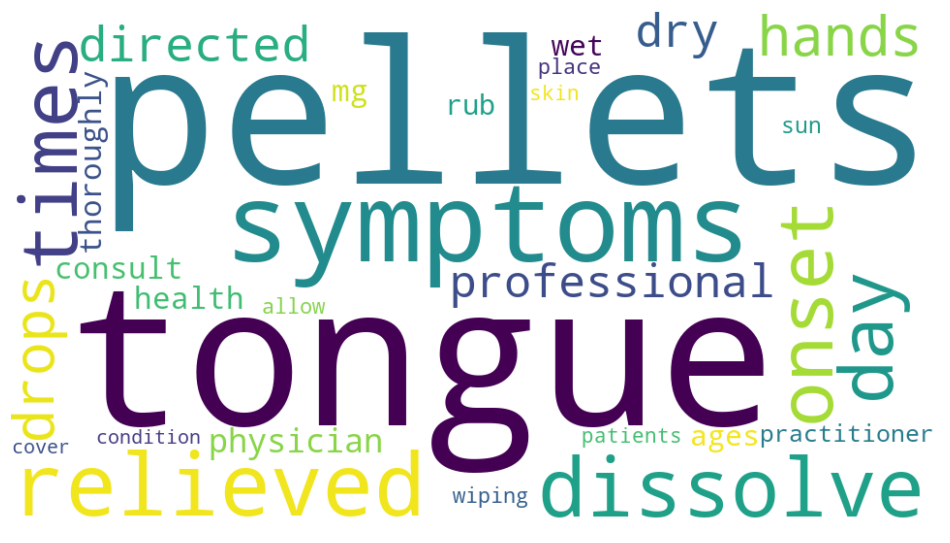

In [122]:
#plot the LSA wordcloud
wordcloud_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names_out())

# Fitting Latent Dirichlet Allocation Model

In [123]:
#prepare the count text vectorizer for the lda model
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df['tokens_str'])
count_text_vectors.shape


c:\Users\Luke-Workstation\Envs\drug-labels\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(85647, 13047)

In [124]:
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=2022)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

# Call `display_topics` on your fitted model here
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  mg (7.22)
  dose (3.96)
  patients (3.21)
  day (2.82)
  daily (2.69)

Topic 01
  dose (1.96)
  patient (1.90)
  patients (1.88)
  tablets (1.63)
  mg (1.53)

Topic 02
  children (4.17)
  years (3.53)
  use (3.21)
  hours (2.63)
  age (2.38)

Topic 03
  injection (2.79)
  mg (2.55)
  dose (2.00)
  ml (1.71)
  patients (1.47)

Topic 04
  mg (4.45)
  dose (3.47)
  patients (2.56)
  daily (1.88)
  day (1.53)


In [125]:
#compare the LDA model to the original tallys
df['Topic'] = W_lda_text_matrix .argmax(axis=1)
pd.crosstab(df['Topic'], df['target'])

target,DENTAL,INTRAMUSCULAR,INTRAVENOUS,ORAL,OTHER,TOPICAL
Topic,,,,,,
0,10,5,59,14490,108,105
1,1,91,7,3431,292,138
2,1383,0,0,22162,3303,27284
3,6,1181,2738,977,1363,357
4,2,109,67,5713,187,78


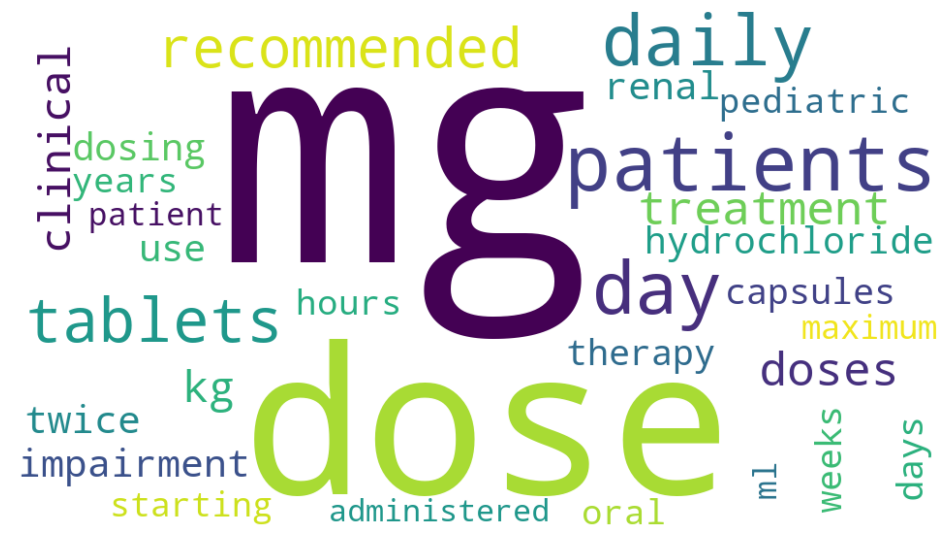

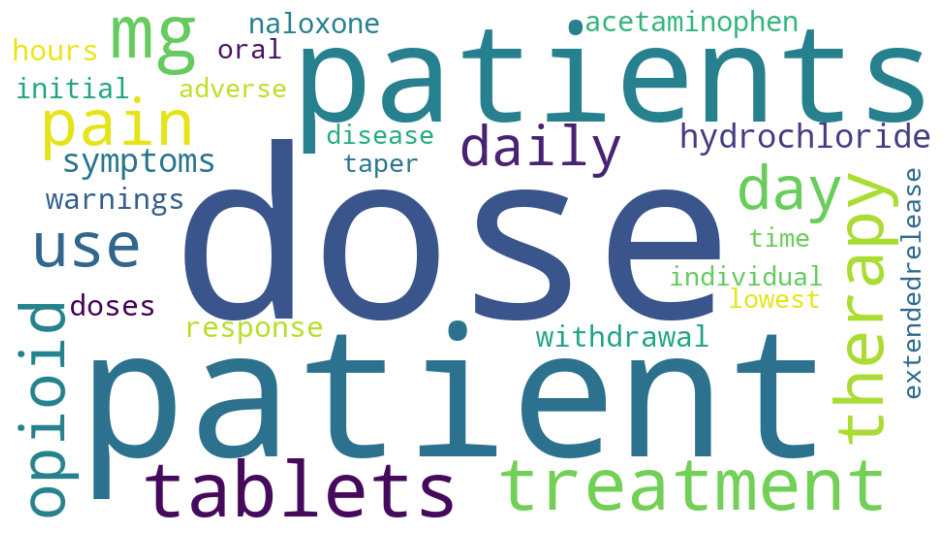

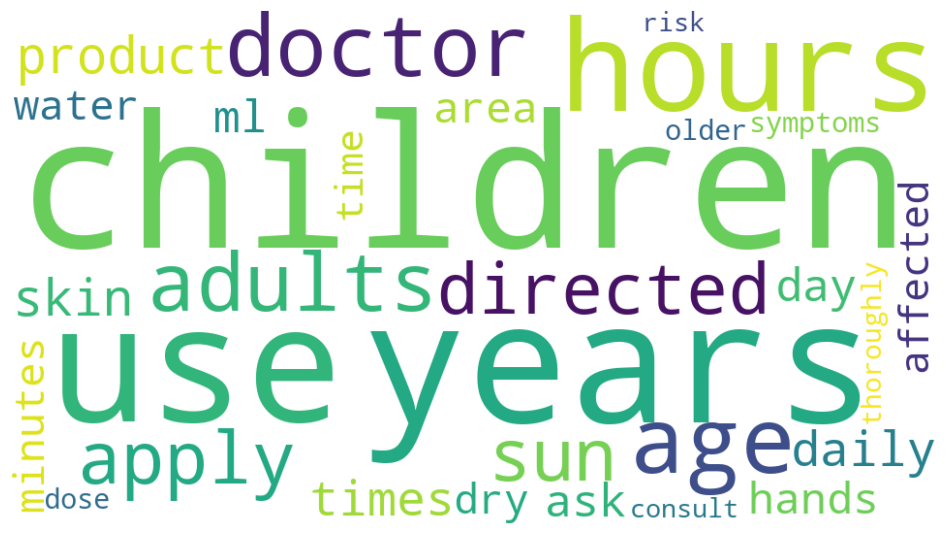

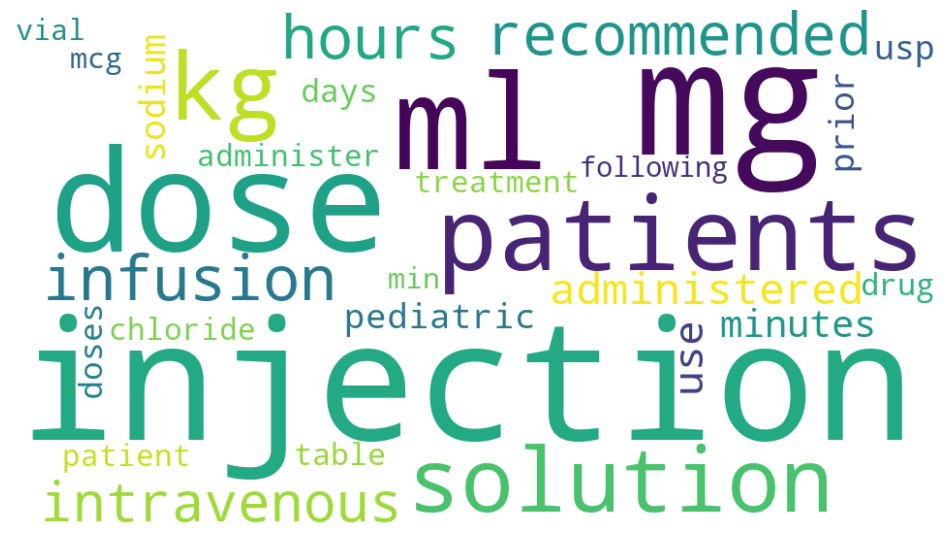

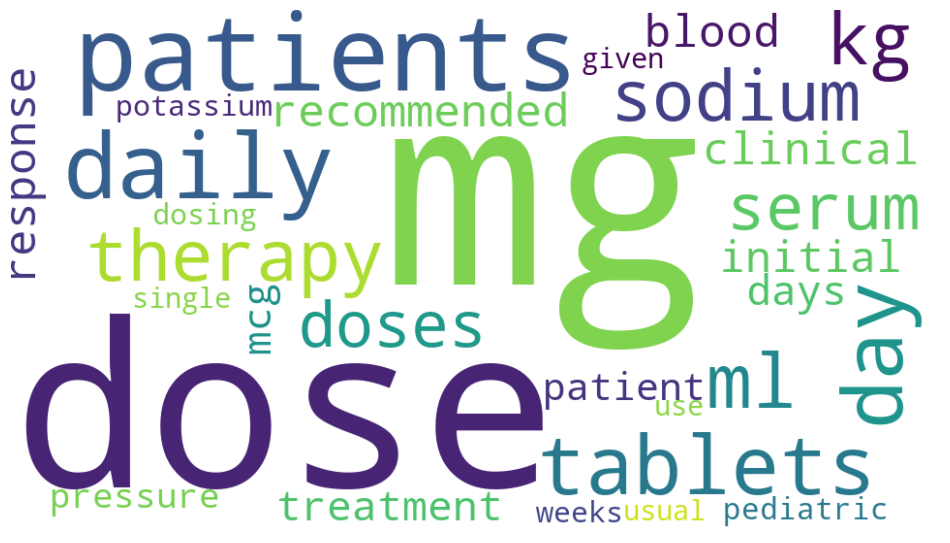

In [126]:
#plot the LDAA wordcloud
wordcloud_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())

In [127]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

c:\Users\Luke-Workstation\Envs\drug-labels\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Luke-Workstation\Envs\drug-labels\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [128]:
pyLDAvis.display(lda_display)

topics 1,5,4 overlap meaning they are related and not unique , topics 2 and 3 are separated from each other indicating unique topics to get better results will tune the model to see if we can get better unique topics

In [129]:
# check the loglikehood score a high scor eis good
print("Log Likelihood: ", lda_text_model.score(count_text_vectors))
# Perplexity score the lower the better
print("Perplexity: ", lda_text_model.perplexity(count_text_vectors))
#model parameters
pprint(lda_text_model.get_params())

Log Likelihood:  -82169887.50569855
Perplexity:  631.6541518039996
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 5,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 2022,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [133]:
filename = 'lsa_model.pkl'
pickle.dump(svd_text_model, open('../models/' + filename, 'wb'))

In [132]:
filename = 'lda_model.pkl'
pickle.dump(lda_text_model, open('../models/' + filename, 'wb'))

In [134]:
filename = 'nmf_model.pkl'
pickle.dump(nmf_text_model, open('../models/' + filename, 'wb'))

In [135]:
# Define Search Param
search_params = {'n_components': [5,10,15], 'learning_decay': [.5, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation()
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(count_text_vectors)

Reference

Prabhakaran, S. (2022, April 28). Lda - how to grid search best topic models? (with examples in python). Machine Learning Plus. Retrieved October 9, 2022, from https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/ 

Albrecht, J., Ramachandran, S., &; Winkler, C. (2020). Blueprints for text analytics using Python: Machine Learning-based solutions for common real world (Nlp) applications. O'Reilly. 